<h1 align="center">Geostatistical Modeling - Final Assignment</h1> 
<h2 align="center">Summer Semester 2021</h2> 

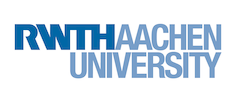

In [22]:
NAME = "Vincent Akinkuoroye"
MATNUM = "404181"

In [23]:
# Here are the usual imports:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic
%matplotlib inline

## Part 1: Data Preparation

In [24]:
df1 = pd.read_csv(r'C:/Users/HP EliteBook 840 G2/Desktop/datasets/dataset28.csv')
df1

,X [km],Y [km],Facies
0,53,47,Facies A
1,74,43,Facies B
2,39,71,Facies A
3,72,11,Facies A
4,23,50,Facies A
...,...,...,...
94,82,44,Facies B
95,90,39,Facies B
96,68,53,Facies A
97,79,42,Facies B


In [25]:
v = []
for f in df1['Facies']:
    if f == 'Facies B':
        v.append(0)
    else:
        v.append(1)
        
df1['New column'] = v
df1

,X [km],Y [km],Facies,New column
0,53,47,Facies A,1
1,74,43,Facies B,0
2,39,71,Facies A,1
3,72,11,Facies A,1
4,23,50,Facies A,1
...,...,...,...,...
94,82,44,Facies B,0
95,90,39,Facies B,0
96,68,53,Facies A,1
97,79,42,Facies B,0


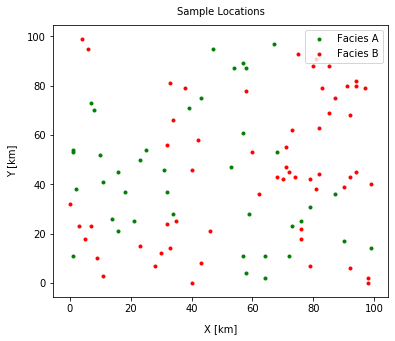

In [26]:
A = []
B = []

for i in range(len(df1['New column'])):
    if (df1['New column'].iloc[i]) == 0:
        A.append(i)
    elif (df1['New column'].iloc[i]) == 1:
        B.append(i)
C = []
D = []

for i in A:
    C.append(df1['X [km]'].iloc[i])
    D.append(df1['Y [km]'].iloc[i])
E = []
F = []
    
for j in B:
    E.append(df1['X [km]'].iloc[j])
    F.append(df1['Y [km]'].iloc[j])
fig, axs = plt.subplots(figsize=(6,5))
plt.scatter(E,F, marker ='.', color = 'g',label ='Facies A' )
plt.scatter(C,D, marker ='.', color = 'r',label ='Facies B' )
plt.title ('Sample Locations', fontsize = 10, pad = 10)
plt.xlabel('X [km]', labelpad=10)
plt.ylabel('Y [km]', labelpad=10)
plt.legend(loc= 'best', fontsize=10)
plt.show()

### Note:
Using the pandas dataframe, we were able to read the chosen dataset (dataset28). For the purpose of Geostatiscal analysis we further went ahead to iterate on each of the strings "Facies A" and "Facies B" with numerical integers 1 and 0 respectively by adding a new column and thereby plotting the location of the sampled datapoints.

## Part 2: Determine a variogram model for the data

Our objective here is determine spatial characteristics by building a model on the basis of the sampled datapoints and therefore discern the highest lag distance with range and sill.

In [27]:
X = df1['X [km]']
Y = df1['Y [km]']
catg = df1['New column']

def all_semivariances(data):
    n = len(X)
    gamma = np.ones((n,n))
    h = np.ones((n,n))
    for i in range(n):
        for j in range(n):
            h[i,j] = np.sqrt(((X[i] - X[j])**2)+ ((Y[i]- Y[j])**2))
            gamma[i,j] = 0.5 *(catg[i] - catg[j])**2
            
            
    return gamma,h
gamma, h = all_semivariances(df1)

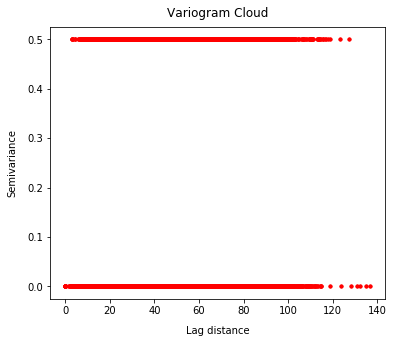

In [28]:
plt.figure(figsize=(6,5))
plt.plot(h.flatten(), gamma.flatten(),'r.')
plt.title('Variogram Cloud', fontsize=12, pad=10)
plt.xlabel('Lag distance', labelpad = 10)
plt.ylabel('Semivariance', labelpad = 10)

plt.show()

### Experimental Variogram

In [29]:
start = 0
stop = 50
lag_s = 2
bin_size = int((stop - start)/lag_s)
h_flat = h.flatten()
gamma_flat = gamma.flatten()
mask_h = np.where(h_flat <= 50)
hn = h_flat[mask_h]
gn = gamma_flat[mask_h]
a_vals = np.zeros(bin_size)
h_bins = np.zeros(bin_size)
boundary_1 = 0
boundary_2 = 2
mask_h = np.where((hn>=(boundary_1))&(hn <=(boundary_2)))
a_vals[0] = np.mean((gn[mask_h]))
h_bins[0] = np.mean((boundary_2, boundary_1))

j = 1
while j > 0 and j < bin_size :
    boundary_1 += 2
    boundary_2 += 2
    mask_h = np.where((hn >boundary_1)&(hn<=boundary_2))
    a_vals[j] = np.mean((gamma_flat[mask_h]))
    h_bins[j] = np.mean((boundary_2, boundary_1))
    j += 1

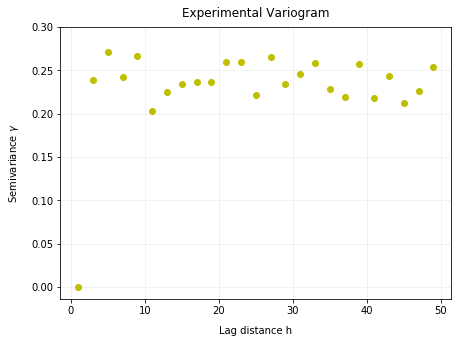

In [30]:
plt.figure(figsize=(7,5))
plt.plot(h_bins, a_vals, 'yo')
plt.grid(True,alpha=0.2)
plt.xlabel('Lag distance h', labelpad = 10)
plt.ylabel('Semivariance $\gamma$', labelpad = 10)
plt.title('Experimental Variogram', fontsize=12, pad=10)
plt.ylim(None,0.3)
plt.show()

### Theoretical (Exponential) Variogram

In [31]:
def exp_var(h_1, a, b):
    l_exp = b * (1 - np.exp((-3 * h_1)/a))
    return l_exp

In [32]:
par_a, par_b = curve_fit(exp_var, h_bins, a_vals)
Range = par_a[0]
sill = par_a[1]
print(" %.2f" %Range)
print(" %.2f" %sill)

 6.00
 0.24


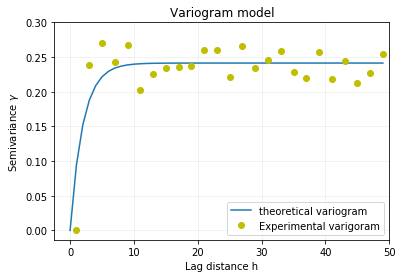

In [33]:
par_a, par_b = curve_fit(exp_var, h_bins, a_vals)

x_lag = np.arange(0,50,1)
plt.plot(x_lag, exp_var(x_lag, Range, sill), label= "theoretical variogram")
plt.plot(h_bins, a_vals, 'yo', label= "Experimental varigoram")
plt.title("Variogram model")
plt.ylabel("Semivariance $\gamma$")
plt.xlabel("Lag distance h")
plt.legend(loc='best', fontsize=10)
plt.grid(True,alpha=0.2)
plt.xlim(None,50)
plt.ylim(None,0.3)
plt.show()

### Note:
As aforementioned in the objective of part 2 we were tasked to model a variogram, in doing this we determined an experimental variogram by choosing suitable bin width and lag distances thereby obtaining variable Range and sill values which were in turn used in fitting the theoretical (exponential) variogram on the experimental variogram.

## Part 3: Ordinary indicator kriging over the full domain

In [34]:
def ordinary_krigging(a,b,prop,Range,sill):
    shape =len(a)
    C = np.zeros((shape+1,shape+1))
    c = np.zeros((shape+1))
    w = np.zeros((shape+1))
    C[:shape,:shape]=exp_var(b, Range, sill)
    c[:shape]=exp_var(a, Range,sill )
    np.fill_diagonal(C,0)
    C[shape,:]=1.0
    C[:,shape]= 1.0
    C[shape,shape]= 0.0
    c[shape]=1.0
    w=np.linalg.solve(C,c)
    w[w<0]=0
    averagemagnitudeofnegativeweights=np.mean(w[w>0])
    averagecovarianceofnegativeweights = np.mean(c[w>0])
    mask =(w>0)&(c<averagecovarianceofnegativeweights) & (w<averagemagnitudeofnegativeweights)
    w[mask]=0
    w = w / np.sum(w)
    predvar = w[shape] + np.sum(w[:shape]*c[:shape])
    result = np.dot(prop,w[:shape])
    return result,predvar,w

In [35]:
x_grid=[]
for i in range(101): 
    if i % 2 ==0:
        for t in range(51): 
                x_grid = np.append(x_grid, i)     
y_grid =[]
for t in range(51): 
    for i in range(101): 
        if i % 2 ==0:
            y_grid = np.append(y_grid, i)

kr_results=[]
kr_predvar =[]
kr_w =[]
X = df1['X [km]']
Y = df1['Y [km]']
catg = df1['New column']
ltarget = [[] for i in range (len(x_grid))]
target=int

for k in range(len(y_grid)): 
    for j in range(len(X)): 
        target = np.sqrt((x_grid[k]-X[j])**2 + (y_grid[k]-Y[j])**2) 
        ltarget[k] = np.append(ltarget[k], target)
               
    k_r, k_p_v, k_we = ordinary_krigging(ltarget[k], h, catg, Range, sill) 
    kr_results = np.append(kr_results, k_r)
    kr_pregvar = np.append(kr_predvar, k_p_v)
    kr_w = np.append(kr_w, k_we)
    

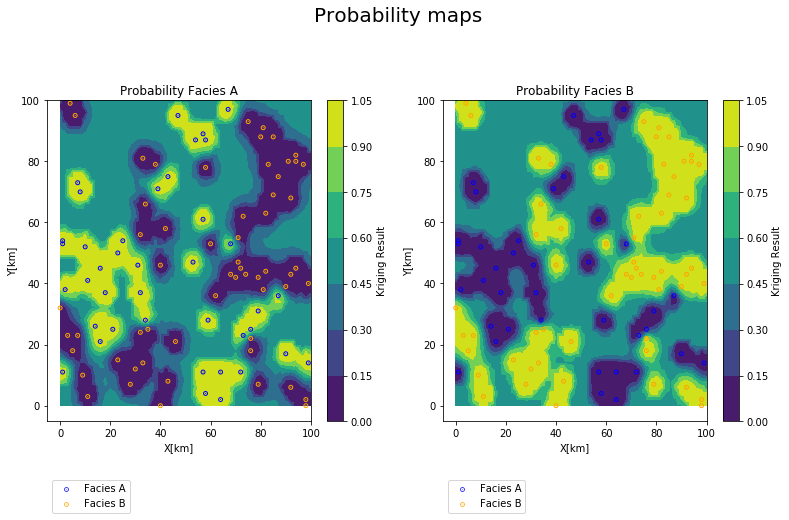

In [36]:
A=np.ones(len(kr_results))
R=A-kr_results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,13), sharey=True)
fig.suptitle('Probability maps', fontsize=20)

plt.subplot(221)
scat = plt.tricontourf(x_grid,y_grid,kr_results, cmap='viridis')
plt.colorbar(scat, label="Kriging Result")
plt.scatter(df1['X [km]'], df1['Y [km]'], df1['New column']==1, color = 'blue',lw =4,  marker ='o', label='Facies A' )
plt.scatter(df1['X [km]'], df1['Y [km]'], df1['New column']==0, color = 'orange',lw =4, marker ='o' ,label='Facies B' )
plt.legend(bbox_to_anchor=(0, -0.3, 1, 0), loc="lower left")
plt.xlabel('X[km]')
plt.ylabel('Y[km]')
plt.title('Probability Facies A')


plt.subplot(222)
scat = plt.tricontourf(x_grid,y_grid,R, cmap='viridis')
plt.colorbar(scat, label="Kriging Result")
plt.scatter(df1['X [km]'], df1['Y [km]'], df1['New column']==1, color = 'blue',lw =4,  marker ='o', label='Facies A' )
plt.scatter(df1['X [km]'], df1['Y [km]'], df1['New column']==0, color = 'orange',lw =4, marker ='o' ,label='Facies B' )
plt.legend(bbox_to_anchor=(0, -0.3, 1, 0), loc="lower left")
plt.xlabel('X[km]')
plt.ylabel('Y[km]')
plt.title('Probability Facies B')


plt.show()

### Note:
While still making use of the sampled datapoints from the choosen dataset, we were able to perform ordinary kriging directly using the variogram function i.e., without a defined covariance function. An empty grid with a predefined domian and resolution was determined and probability maps was established.

## Part 4: Convert to facies map

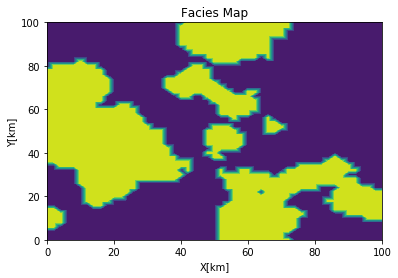

In [37]:
#facies A or B
kriging_facies = np.zeros(2601)
kriging_facies[kr_results >= 0.5] = 1 
kriging_facies[kr_results < 0.5] = 0

plt.tricontourf(x_grid,y_grid,kriging_facies, cmap='viridis')
plt.xlabel('X[km]')
plt.ylabel('Y[km]')
plt.title('Facies Map')
plt.show()

### Note:
By predefining the probable outcomes to 1 or 0, the kriging results were converted to categorical facies and plotted

## Part 5: Performing sequential simulation

In [38]:
#define grid 25x25 resolution
sx_grid=[]
for i in range(26):  
    for t in range(26):
        sx_grid = np.append(sx_grid, i*4)     


sy_grid =[]
for t in range(26): 
    for i in range(26):
        sy_grid = np.append(sy_grid, i*4)

skr_results=[]
skr_predvar =[]
skr_w =[]
X = df1['X [km]']
Y = df1['Y [km]']
catg = df1['New column']
slist_kr = [[] for i in range (len(x_grid))]
sp=int

for k in range(len(sy_grid)): 
    for j in range(len(X)): 
        sp = np.sqrt((sx_grid[k]-X[j])**2 + (sy_grid[k]-Y[j])**2) 
        slist_kr[k] = np.append(slist_kr[k], sp)
               
    sk_r, sk_p_v, sk_we = ordinary_krigging(slist_kr[k], h, catg, Range, sill) 
    skr_results = np.append(skr_results, sk_r)
    skr_pregvar = np.append(skr_predvar, sk_p_v)
    skr_w = np.append(skr_w, sk_we)

In [39]:
simulated_values = []
outcomes = np.array([1,0])
np.random.seed(12345)
for i in range(len(skr_results)):
    value_random_location = skr_results[i] 
    variance_random_location = skr_w[i] 
    sim_val = np.random.choice(a = outcomes, p= [skr_results[i], 1-skr_results[i]])
    simulated_values.append(sim_val)

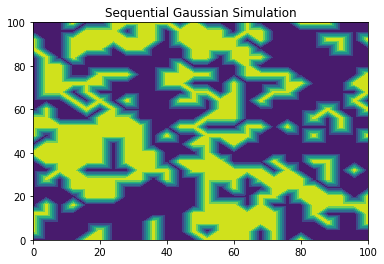

In [40]:
plt.title('Sequential Gaussian Simulation');
plt.tricontourf(sx_grid,sy_grid,simulated_values, cmap='viridis')
plt.show()

### Note:
In interpolating Kriging, there seem to be an overestimation of small values and an underestimation of large values which is regarded as smoothing effect, geostatistical or stochastic simulations such as the Sequential gaussian simulation annuls this effect, thereby describing a local variability (Castrignano and Buttafuoco, 2004). In the estimates, using kriging estimates as the mean and kriging variance as the variance we established the correct global spatial variation.

## Part 6: Creating multiple realizations using simulation

In [41]:
omega = [[] for i in range(10)]
for i in range(10):
    for k in range(len(sy_grid)): 
        s_k_r, s_k_p_v, s_k_w = ordinary_krigging(slist_kr[k], h, catg, Range, sill)
        prob = np.random.choice(a = outcomes, p= [s_k_r, 1- s_k_r]) 
        omega[i] = np.append(omega[i], prob)

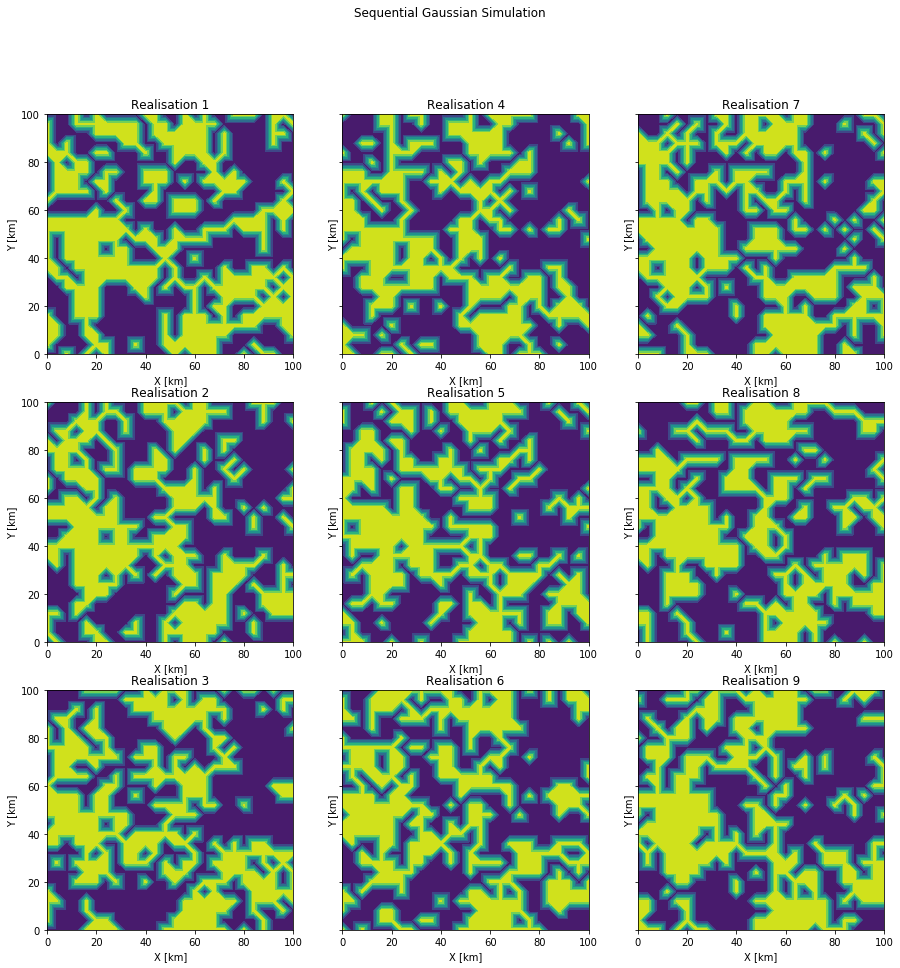

In [42]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15), sharey=True)
fig.suptitle('Sequential Gaussian Simulation ')


axs[0][0].tricontourf(sx_grid,sy_grid,omega[0], cmap='viridis')
axs[0][0].set_title('Realisation 1' )
axs[0][0].set_xlabel('X [km]')
axs[0][0].set_ylabel('Y [km]')

axs[1][0].tricontourf(sx_grid,sy_grid,omega[1], cmap='viridis')
axs[1][0].set_title('Realisation 2' )
axs[1][0].set_xlabel('X [km]')
axs[1][0].set_ylabel('Y [km]')

axs[2][0].tricontourf(sx_grid,sy_grid,omega[2], cmap='viridis')
axs[2][0].set_title('Realisation 3' )
axs[2][0].set_xlabel('X [km]')
axs[2][0].set_ylabel('Y [km]')

axs[0][1].tricontourf(sx_grid,sy_grid,omega[3], cmap='viridis')
axs[0][1].set_title('Realisation 4' )
axs[0][1].set_xlabel('X [km]')
axs[0][1].set_ylabel('Y [km]')

axs[1][1].tricontourf(sx_grid,sy_grid,omega[4], cmap='viridis')
axs[1][1].set_title('Realisation 5' )
axs[1][1].set_xlabel('X [km]')
axs[1][1].set_ylabel('Y [km]')

axs[2][1].tricontourf(sx_grid,sy_grid,omega[5], cmap='viridis')
axs[2][1].set_title('Realisation 6' )
axs[2][1].set_xlabel('X [km]')
axs[2][1].set_ylabel('Y [km]')

axs[0][2].tricontourf(sx_grid,sy_grid,omega[6], cmap='viridis')
axs[0][2].set_title('Realisation 7' )
axs[0][2].set_xlabel('X [km]')
axs[0][2].set_ylabel('Y [km]')

axs[1][2].tricontourf(sx_grid,sy_grid,omega[7], cmap='viridis')
axs[1][2].set_title('Realisation 8' )
axs[1][2].set_xlabel('X [km]')
axs[1][2].set_ylabel('Y [km]')

axs[2][2].tricontourf(sx_grid,sy_grid,omega[8], cmap='viridis')
axs[2][2].set_title('Realisation 9' )
axs[2][2].set_xlabel('X [km]')
axs[2][2].set_ylabel('Y [km]')

plt.show()

### Note:
In creating multiple realisations from the SGS through iteration we strongly captured the heterogeneous character of each simulation which can be useful in assessing uncertainty within the dataset. Goovaerts, 2001 expressed this significancy "However, generating a set of equiprobable realizations and using differences among them to measure of uncertainty is another advantage of stochastic simulation compared with kriging approaches, which makes it more common in uncertainty modeling".

## Part 7: Interpretation and results discussion

The general idea for this analysis, including the interpolation and simulation is the non-stationarity of the sampled datapoints in our datasets, ordinary kriging treats the variables independently with the spatial domain. The sampled datapoints were first visualized before the variogram was modeled to pattern the behaviour of the datapoints, this was done in a bid to establish a geostatistical spatial relationship. Which brings about the experimental variogram, variogram considers the measure of disimilarity or semivariance and the lag distance, which was predefined to be 50 with an appropriate bin size. The oucome of the experimental variogram is from the process of binning, the range and sill were also obtained which were further used in the ordinary kriging interpolation.

For the purpose of achieving a smoothing effect, ordinary kriging was introduced for multiple variables and achieving an independet result, in an estimation context, using the variogram function and in other to achieve accuracy and local variability. In other to achieve reduction in the smoothness and a better representation of the spatial relationship, the Sequential Gaussian simulation was introduced, which is fast and more efficient, which shows a better heterogeneity in assessing uncertainties. Multiple realisations were made from this which is an advantageous edge for stochastic simulations such as SGS